# 线性回归分析

提示词：

翻译为中文，讲义风格。为了符合中文表述喜欢，可以适当意译。
关键变量，如 Y, X 都用 Latex 格式，即 $Y$, $X$
所有圆括号都采用半角模式；
中英文混排加空格。

Source: Chernozhukov, V. & Hansen, C. & Kallus, N. & Spindler, M. & Syrgkanis, V. (**2024**): Applied Causal Inference Powered by ML and AI. [CausalML-book.org](https://causalml-book.org/); arXiv:2403.02467. [-PDF-](https://arxiv.org/pdf/2403.02467)，[Website](https://causalml-book.org/), [github](https://github.com/CausalAIBook/MetricsMLNotebooks) &rarr; [This Note](https://github.com/CausalAIBook/MetricsMLNotebooks/blob/main/PM1/python-ols-and-lasso-for-wage-prediction.ipynb) 

## 简介

在劳动经济学中，一个核心问题是：工人的工资 $Y$ 由什么因素决定？虽然这是一个因果推断问题，但我们可以先从预测的角度进行分析。

在下面的工资案例中，$Y$ 表示工人的（对数）小时工资，$X$ 是工人的特征向量，例如教育、工作经验、性别等。这里我们关注两个主要问题：

* 如何利用与工作相关的特征（如教育和经验）更好地预测工资 $Y$？
* 在其他工作相关特征 $X$ 相同的情况下，男性和女性工人的预测工资有何不同？

本实验首先聚焦于回归分析和预测问题。

## 数据说明

本次分析的数据来源于 2015 年美国现行人口调查（CPS）三月补充调查。我们筛选了 25 至 64 岁的白人非西班牙裔个体，要求每年工作超过 50 周且每周工作时间超过 35 小时。排除了自雇人员、居住在集体宿舍的个体、军人、农业或私人家庭部门的个体，以及在收入和就业状态报告上存在不一致、变量有缺失或分配信息的观测，同时剔除了小时工资低于 3 的样本。

我们关注的核心变量 $Y$，即（对数）小时工资率，是由年收入除以总工作小时数得到的。其中，总工作小时数等于每年工作周数乘以每周通常工作小时数。在分析中，我们还聚焦于未婚（从未结婚）工人。最终样本量为 $n=5150$。


### 变量标签与变量解释

下面列示了该数据集中每个变量的常用英文标签及中文解释说明。部分变量根据 CPS 典型设定和相关代码本推断并补充。


| 变量名   | 英文标签                         | 中文解释                          |
| -- | - | -- |
| wage  | Hourly wage                  | 小时工资（美元）                      |
| lwage | Log hourly wage              | 小时工资的对数                       |
| sex   | Female (1=Female)            | 性别（女性=1，男性=0）                 |
| shs   | <12 years of schooling       | 教育年限未满 12 年（未完成高中）            |
| hsg   | High school graduate         | 高中毕业                          |
| scl   | Some college                 | 大学肄业（上过大学但未获得学位）              |
| clg   | College graduate             | 大学毕业（获得学士学位）                  |
| ad    | Advanced degree              | 研究生学历（硕士或博士）                  |
| mw    | Midwest region               | 美国中西部地区（居住地）                  |
| so    | South region                 | 美国南部地区（居住地）                   |
| we    | West region                  | 美国西部地区（居住地）                   |
| ne    | Northeast region             | 美国东北地区（居住地）                   |
| exp1  | Potential experience         | 潜在工作经验年数（age - education - 6） |
| exp2  | Potential experience squared | 潜在工作经验年数的平方                   |
| exp3  | Potential experience cubed   | 潜在工作经验年数的三次方                  |
| exp4  | Potential experience^4       | 潜在工作经验年数的四次方                  |
| occ   | Occupation code              | 职业代码（细分，通常为 3-5 位数）           |
| occ2  | Major occupation group       | 职业大类代码（22 类）                  |
| ind   | Industry code                | 行业代码（细分，通常为 3-5 位数）           |
| ind2  | Major industry group         | 行业大类代码（22 类）                  |


### 变量进一步解释和常见分组

* **学历变量（shs, hsg, scl, clg, ad）**
  这些是**互斥**的 dummy 变量，每个人只能属于其中一个。常见定义如下：

  * `shs`: 小于高中毕业（未完成高中学业）
  * `hsg`: 高中毕业但没有上过大学
  * `scl`: 上过大学但未毕业（包括两年制大学、部分大学课程等，未获得学位）
  * `clg`: 获得学士学位（本科毕业）
  * `ad`: 获得更高学位（硕士及以上）

* **地区变量（mw, so, we, ne）**
  根据居住地划分的美国四大区域，具体可以参考美国人口调查标准地区定义。

* **经验变量（exp1, exp2, exp3, exp4）**
  经验变量通常由公式 $exp1 = \text{age} - \text{years of schooling} - 6$ 计算，近似代表进入劳动力市场的年数，其高次项常用于工资方程中的经验-工资非线性关系建模。

* **职业/行业变量（occ, occ2, ind, ind2）**

  * `occ`/`ind` 为细分的职业/行业代码，通常来自于 CPS 的详细分类。
  * `occ2`/`ind2` 则为大类分组，便于建模和控制大类异质性。


### 参考说明与代码本依据

这些变量的定义可参考 CPS（Current Population Survey）文档和相关学术论文，例如：

- Angrist, J. D., & Pischke, J.-S. (2009). *Mostly Harmless Econometrics: An Empiricist's Companion*. Princeton University Press. [Link](https://press.princeton.edu/books/paperback/9780691120355/mostly-harmless-econometrics), [Google](https://scholar.google.com/scholar?q=Mostly+Harmless+Econometrics).
- Card, D., & Krueger, A. B. (1992). School Quality and Black-White Relative Earnings: A Direct Assessment. *Quarterly Journal of Economics*, 107(1), 151–200. [Link](https://doi.org/10.2307/2118323), [PDF](http://sci-hub.ren/10.2307/2118323), [Google](https://scholar.google.com/scholar?q=School+Quality+and+Black-White+Relative+Earnings).


### 相关 R/Python 代码标签举例

常见的学历 dummies 在原始代码中的构造（R/Python 通用思路）：

```python
# Python 示意
df["shs"] = (df["educ"] < 12).astype(int)
df["hsg"] = (df["educ"] == 12).astype(int)
df["scl"] = ((df["educ"] > 12) & (df["educ"] < 16)).astype(int)
df["clg"] = (df["educ"] == 16).astype(int)
df["ad"] = (df["educ"] > 16).astype(int)
```


In [2]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import sklearn.linear_model as lm
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import warnings
# ignore potential convergence warnings; for some small penalty levels,
# tried out, optimization might not converge
warnings.simplefilter('ignore')

## 基本数据分析

本节将对数据进行初步分析，包括：

- 生成一些新变量，以便于后续分组绘图；
- 探索性数据分析：采用散点图、箱线图、小提琴图等可视化工具，分析工资在不同子样本 (不同教育水平、不同地区、不同性别等) 下的分布情况，以便初步了解工资与各个特征之间的关系；
- 计算工资的描述性统计量（均值、中位数、标准差等）；
- 采用分仓散点图和回归线，分析工资与潜在工作经验之间的关系。


In [ ]:
# 导入数据

file = "https://raw.githubusercontent.com/CausalAIBook/MetricsMLNotebooks/main/data/wage2015_subsample_inference.csv"
df = pd.read_csv(file)

df.columns

Index(['wage', 'lwage', 'sex', 'shs', 'hsg', 'scl', 'clg', 'ad', 'mw', 'so',
       'we', 'ne', 'exp1', 'exp2', 'exp3', 'exp4', 'occ', 'occ2', 'ind',
       'ind2'],
      dtype='object')

### 变量生成及变量标签

在本节中，我们将对数据集进行变量生成和标签定义，以便后续分析和建模。

- 基于 sex 生成新变量：带标签的变量 sex_label
  - `sex_label`：{0: Male; 1: Female}，表示性别。我们将其转换为字符串标签。

- 教育水平和地区
  - 定义一个新变量：edu_group，表示教育水平的分组，取值为 `{'shs': '<HS', 'hsg': 'HS', 'scl': 'Some College', 'clg': 'College', 'ad': 'Advanced'}`。后续分析中采用这个变量更便于分组绘图和统计分析。
  - 定义一个新变量：regeion，表示居住地区的分组，取值为 `{'mw': 'Midwest', 'so': 'South', 'we': 'West', 'ne': 'Northeast'}`。后续分析中采用这个变量更便于分组绘图和统计分析。


In [8]:
# 基于 sex 生成 sex_label 变量（0: Male, 1: Female），并转换为字符串标签
df['sex_label'] = df['sex'].map({0: 'Male', 1: 'Female'})

# 定义 edu_group 变量
edu_map = {'shs': '<HS', 'hsg': 'HS', 'scl': 'Some College', 'clg': 'College', 'ad': 'Advanced'}
def get_edu_group(row):
    for k in edu_map:
        if row[k] == 1:
            return edu_map[k]
    return None
df['edu_group'] = df.apply(get_edu_group, axis=1)

# 定义 region 变量
region_map = {'mw': 'Midwest', 'so': 'South', 'we': 'West', 'ne': 'Northeast'}
def get_region(row):
    for k in region_map:
        if row[k] == 1:
            return region_map[k]
    return None
df['region'] = df.apply(get_region, axis=1)

In [222]:
# 变量清单

df.columns

Index(['wage', 'lwage', 'sex', 'shs', 'hsg', 'scl', 'clg', 'ad', 'mw', 'so',
       'we', 'ne', 'exp1', 'exp2', 'exp3', 'exp4', 'occ', 'occ2', 'ind',
       'ind2', 'sex_label', 'edu_group', 'region'],
      dtype='object')

In [223]:
# 描述性统计量
cols_to_exclude = ['exp2', 'exp3', 'exp4', 'occ', 'ind']
desc = df.drop(columns=cols_to_exclude).describe().T[['count', 'mean', 'std', 'min', 'max']]
desc = desc.rename(columns={'count': 'N', 'std': 'sd'})
print(desc.round(2))

            N   mean     sd   min     max
wage   5150.0  23.41  21.00  3.02  528.85
lwage  5150.0   2.97   0.57  1.11    6.27
sex    5150.0   0.44   0.50  0.00    1.00
shs    5150.0   0.02   0.15  0.00    1.00
hsg    5150.0   0.24   0.43  0.00    1.00
scl    5150.0   0.28   0.45  0.00    1.00
clg    5150.0   0.32   0.47  0.00    1.00
ad     5150.0   0.14   0.34  0.00    1.00
mw     5150.0   0.26   0.44  0.00    1.00
so     5150.0   0.30   0.46  0.00    1.00
we     5150.0   0.22   0.41  0.00    1.00
ne     5150.0   0.23   0.42  0.00    1.00
exp1   5150.0  13.76  10.61  0.00   47.00
occ2   5150.0  11.67   6.97  1.00   22.00
ind2   5150.0  13.32   5.70  2.00   22.00


### 不同职业类别的工资分布

In [224]:
# 按照 occ2 分组，计算每个职业类别的平均工资
stats = ['count', 'mean', 'std', 'min', 'median', 'max']
wage_by_occ2 = df.groupby('occ2')['wage'].agg(stats).reset_index()
wage_by_occ2.columns = ['occ2'] + stats
print(wage_by_occ2.round(1))

    occ2  count  mean   std  min  median    max
0      1    603  30.3  19.5  4.2    25.6  153.8
1      2    331  30.9  24.7  4.2    25.5  276.9
2      3    224  31.9  15.8  5.5    28.8  120.2
3      4    106  28.2  11.3  5.7    27.3   60.1
4      5     73  28.9  14.1  4.2    26.9   76.9
5      6    120  19.6   8.8  5.5    19.2   72.1
6      7     92  39.6  34.2  9.7    29.1  240.4
7      8    271  21.4  10.3  4.3    19.2   72.1
8      9    142  26.2  16.6  3.1    21.6   96.2
9     10    301  30.4  31.9  4.8    24.0  384.6
10    11     86  14.4   6.5  4.3    13.5   51.2
11    12    103  23.8  15.5  4.8    17.9   74.2
12    13    237  13.3   6.0  3.8    12.0   43.7
13    14    117  14.4   6.6  4.3    13.5   51.9
14    15    117  15.0   7.2  3.0    14.3   43.3
15    16    546  24.4  39.9  3.8    17.3  528.8
16    17    670  17.7   8.4  4.8    16.2   64.1
17    18      6  21.3  15.8  8.7    17.5   52.0
18    19    229  20.6  10.4  6.4    17.5   65.8
19    20    208  21.2  10.2  3.4    19.2

<Figure size 1000x600 with 0 Axes>

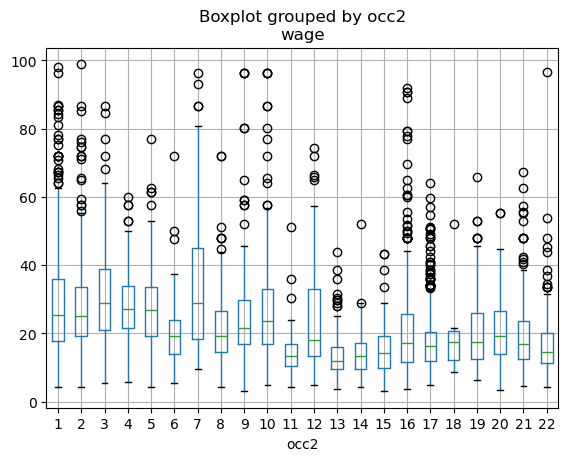

In [ ]:
# 箱线图：不同职业类别的工资分布
# 只绘制工资小于100的样本，以避免极端值影响图形

import matplotlib.pyplot as plt

plt.figure(figsize = (10, 6))
df[df['wage']<100].boxplot(column='wage', by='occ2')
plt.show()

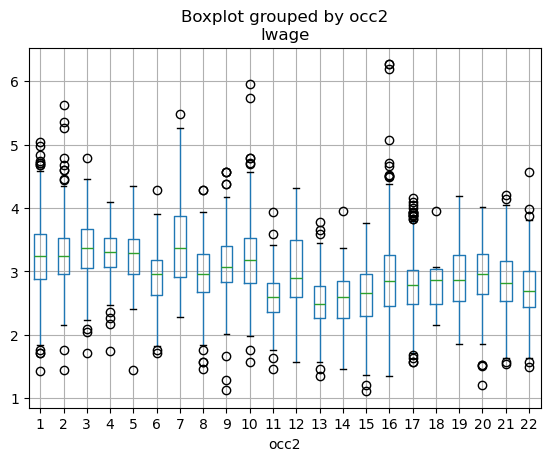

In [ ]:
# 对数工资 ln(wage): boxplot 

import matplotlib.pyplot as plt

df.boxplot(column='lwage', by='occ2')
plt.show()

### 不同行业类别的工资分布

In [23]:
# 按照 ind2 分组，计算每个行业类别的样本数、平均工资和工资标准差
stats = ['count', 'mean', 'std', 'min', 'max']
wage_by_ind2 = df.groupby('ind2')['wage'].agg(stats).reset_index()
wage_by_ind2.columns = ['ind2'] + stats
print(wage_by_ind2.round(2))

    ind2  count   mean    std   min     max
0      2     45  30.06  19.34  6.32  111.54
1      3     52  26.58  14.88  6.84   72.12
2      4    297  21.06  10.20  4.81   60.58
3      5    195  22.78  14.67  5.29  106.84
4      6    373  21.64  11.92  4.52   78.08
5      7     69  29.58  57.51  4.33  490.20
6      8     67  23.73  19.11  6.99  145.96
7      9    616  20.66  32.82  3.37  528.85
8     10    143  20.05  11.00  7.21   96.63
9     11    169  29.65  20.39  3.08  115.38
10    12    284  31.39  23.91  5.12  240.38
11    13     84  24.55  12.65  6.29   67.31
12    14    484  31.31  29.56  4.57  384.62
13    15     14  24.91  11.44  9.13   50.00
14    16    185  19.50  17.68  4.43  213.46
15    17    408  23.17  11.51  4.25   96.15
16    18    664  21.97  14.73  4.33  120.19
17    19    108  19.36  12.26  3.02   86.54
18    20    363  14.54   7.56  3.85   48.08
19    21    223  20.95  12.02  4.81  111.34
20    22    307  28.21  16.63  3.90  126.92


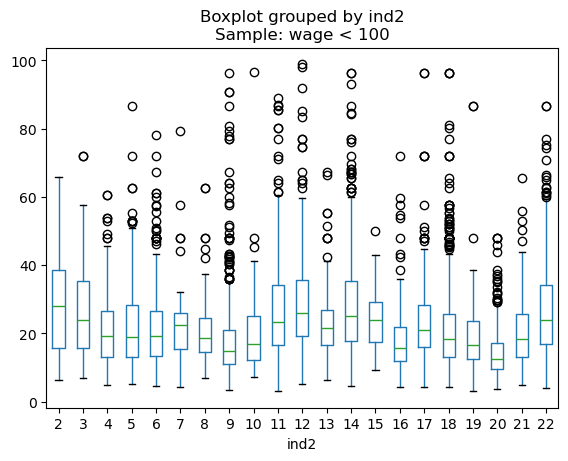

In [ ]:
# 箱线图：不同行业类别的工资分布

import matplotlib.pyplot as plt

df[df['wage'] < 100].boxplot(column='wage', by='ind2', grid=False)
plt.title('Sample: wage < 100')
plt.show()

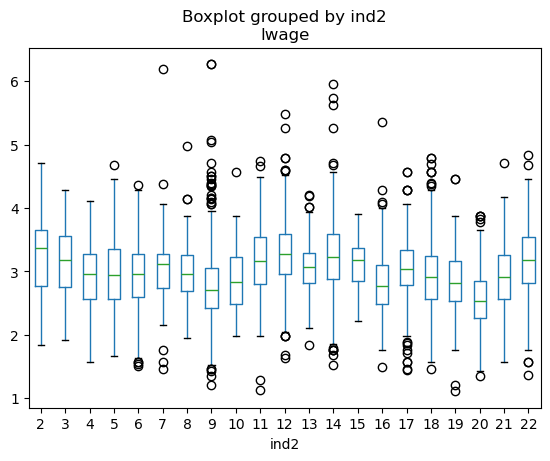

In [25]:
# 对数工资 ln(wage): boxplot 不同行业类别

import matplotlib.pyplot as plt

df.boxplot(column='lwage', by='ind2', grid=False)
plt.show()

## 不同教育水平的工资分布

使用 `edu_group` 变量绘制不同教育水平的工资分布图。可以使用箱线图（boxplot）或小提琴图（violin plot）来展示不同教育水平下工资的分布情况。

::: {.callout-tip}
### 提示词
使用 `edu_group` 变量绘制不同教育水平的工资分布图：

- 小提琴图：颜色-深黄色；
- 纵轴刻度：0(5)100；
- Sample: wage < 100；
- 添加浅灰色横向网格线，间隔 5

:::


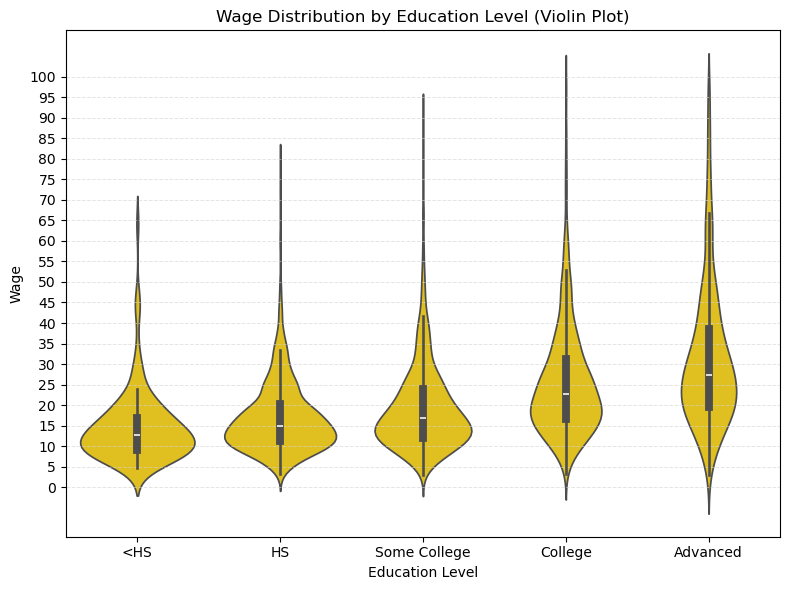

In [26]:
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.violinplot(
    data=df_wage_less_100,
    x='edu_group', y='wage',
    order=edu_labels,
    inner='box', color='#FFD600'  # 深黄色
)
plt.xlabel('Education Level')
plt.ylabel('Wage')
plt.title('Wage Distribution by Education Level (Violin Plot)')
plt.grid(axis='y', color='lightgray', linestyle='--', linewidth=0.7, alpha=0.6)
plt.yticks(np.arange(0, df_wage_less_100['wage'].max() + 2, 5))
plt.tight_layout()
plt.show()

### 箱线图：不同教育水平的工资分布

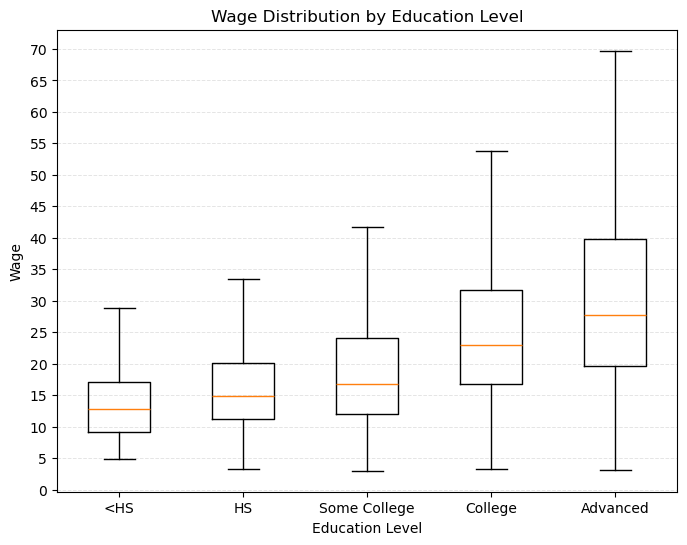

In [27]:
import matplotlib.pyplot as plt

edu_vars = ['shs', 'hsg', 'scl', 'clg', 'ad']
edu_labels = ['<HS', 'HS', 'Some College', 'College', 'Advanced']

# 为每个学历子样本绘制工资箱线图
wage_data = [df[df[edu]==1]['wage'] for edu in edu_vars]

plt.figure(figsize=(8, 6))
plt.boxplot(wage_data, labels=edu_labels, showfliers=False)
plt.xlabel('Education Level')
plt.ylabel('Wage')
plt.grid(axis='y', color='lightgray', linestyle='--', linewidth=0.7, alpha=0.6)
plt.yticks(np.arange(0, df_wage_less_100['wage'].max() -25, 5))
plt.title('Wage Distribution by Education Level')
plt.show()

### 不同教育水平下的工资性别差异

::: {.callout-tip}
### 提示词
在每个教育水平组内，进一步区分 Male 和 Female，绘制箱线图。
- 箱线图箱体填充色 Male: 深蓝色；Female：金黄色
- legend：放在左上角
- y 轴范围：0(10)80
:::

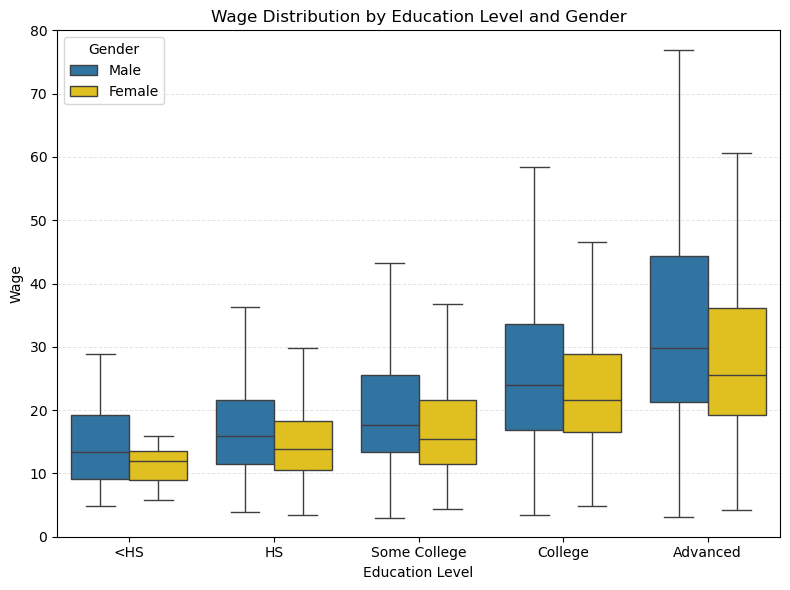

In [30]:
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.boxplot(
    data=df_plot,
    x='edu_group',
    y='wage',
    hue='sex_label',
    order=edu_labels,
    hue_order=gender_order,
    showfliers=False,
    palette={'Male': '#1f77b4', 'Female': '#FFD600'}  # 深蓝色和金黄色
)
plt.xlabel('Education Level')
plt.ylabel('Wage')
plt.title('Wage Distribution by Education Level and Gender')
plt.grid(axis='y', color='lightgray', linestyle='--', linewidth=0.7, alpha=0.6)
plt.yticks(np.arange(0, 81, 10))
plt.ylim(0, 80)
plt.legend(title='Gender', loc='upper left')
plt.tight_layout()
plt.show()

按区域和性别来展示工资的箱线图。

- 首先，根据地区（region）和性别（sex）将原始数据 `df` 转换成长格式 `long_df_region`，便于后续分组绘图。
- 接着，利用 seaborn 的 `boxplot` 和 `stripplot`，分别绘制了不同地区和性别组合下工资（`wage` 或 `lwage`）的箱线图和散点分布。


### 不同地区的工资分布

::: {.callout-tip}
### 提示词

1. 使用 `region` 变量绘制不同地区 Male 和 Female 的工资分布图：
2. 箱线图 + 散点图
3. 箱线图：无需填充箱体颜色
   - 边框颜色：Male-深蓝色；Female-深黄色；
   - 纵轴刻度：0(5)100；添加浅灰色横向网格线
   - Sample: wage < 100；
4. 散点：Male-深蓝色；Female-深黄色；透明度：0.18
5. legend: 能区分 Male 和 Female 即可 

:::

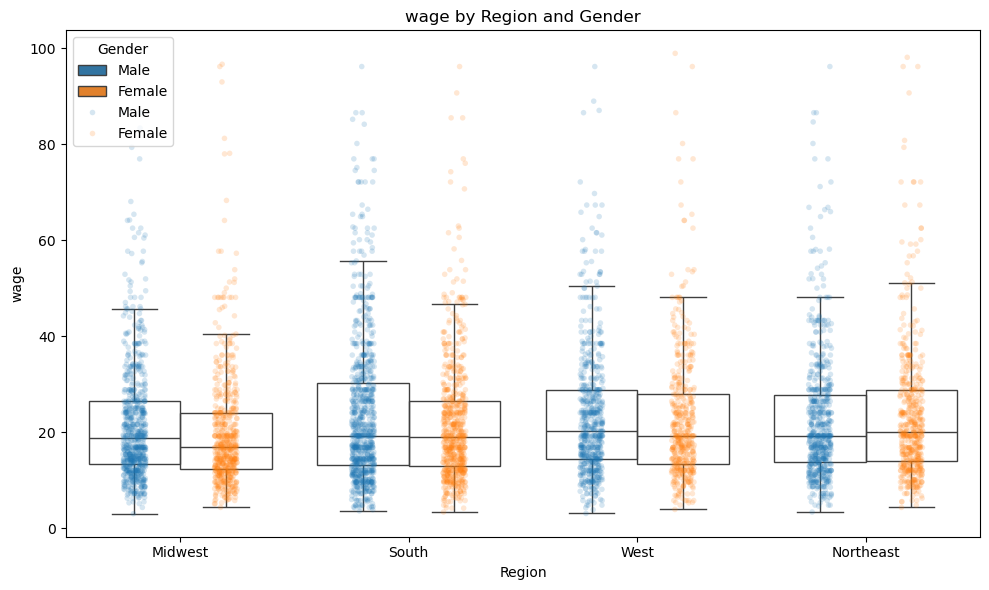

In [10]:
# {cell-label-region_sex}

import seaborn as sns
import matplotlib.pyplot as plt

# yvar 可以为 'wage' 或 'lwage'
yvar = 'wage'   # 或 'lwage'
#yvar = 'lwage'

region_vars = ['mw', 'so', 'we', 'ne']
region_labels = ['Midwest', 'South', 'West', 'Northeast']

# 宽转长：只保留每个人的所在地区
long_df_region = pd.DataFrame()
for var, label in zip(region_vars, region_labels):
    tmp = df[df[var] == 1].copy()
    tmp['Region'] = label
    long_df_region = pd.concat([long_df_region, tmp], axis=0)
long_df_region = long_df_region.reset_index(drop=True)

# 性别英文标签
long_df_region['Gender'] = long_df_region['sex'].map({0: 'Male', 1: 'Female'})

# 保证 Male 在左，Female 在右
gender_order = ['Male', 'Female']
palette = {'Male': '#1f77b4', 'Female': '#ff7f0e'}  # 深蓝和橙色

plt.figure(figsize=(10, 6))
sns.boxplot(
    data=long_df_region,
    x='Region',
    y=yvar,
    hue='Gender',
    order=region_labels,
    hue_order=gender_order,
    showfliers=False,
    palette=palette,
    boxprops={'facecolor': 'none'}  # 不填充箱体颜色
)
sns.stripplot(
    data=long_df_region[long_df_region[yvar] < 100],  # 只显示低工资点，若画 wage 可改为 <100
    x='Region',
    y=yvar,
    hue='Gender',
    order=region_labels,
    hue_order=gender_order,
    dodge=True,
    alpha=0.18,
    size=4,
    marker='o',
    palette=palette
)

plt.xlabel('Region')
plt.ylabel(yvar)
plt.title(f'{yvar} by Region and Gender')
plt.legend(title='Gender', loc='upper left')
plt.tight_layout()
plt.show()

简要分析：

- 男性和女性在不同地区的工资分布存在明显差异，尤其是在 '中西部 (Midwest)' 和 '西部 (West)' 地区，男性的工资中位数普遍高于女性。不过，这种工资的性别差异相比于教育水平的差异要小得多。
- 在 '南部 (South)'，男性和女性的工资分布较为接近。
- 在 '东北部 (Northeast)'，女性的工资甚至略高于男性。

### 组间均值差异检验

在实际经济与社会数据分析中，我们经常需要比较两个不同群体（如男性与女性、实验组与对照组、不同地区等）的平均水平是否存在统计学上的显著差异。例如，在本例中，我们关注 Midwest 区域男性与女性的平均工资是否不同。这一问题本质上属于**组间均值差异检验**。

#### 检验思路

假设有两组独立观测值 $X_{1,1}, ..., X_{1,n_1}$（如男性工资）与 $X_{2,1}, ..., X_{2,n_2}$（如女性工资），我们关注这两组样本的均值是否存在显著差异。统计学上，常用的检验方法是**两独立样本 t 检验**。

* **原假设**（$H_0$）：两组总体均值相等，即 $ \mu_1 = \mu_2 $
* **备择假设**（$H_1$）：两组总体均值不等，即 $ \mu_1 \neq \mu_2 $

#### t 统计量的构建与分布

假设两组观测值独立，且服从正态分布。若不假定两组方差相等（更贴合实际），则采用 Welch t 检验，t 统计量的计算公式为：

$$
t = \frac{ \bar{X}_1 - \bar{X}_2 }{ \sqrt{ \frac{S_1^2}{n_1} + \frac{S_2^2}{n_2} } } \sim t(k)
$$

其中：

* $ \bar{X}_1, \bar{X}_2 $ 为两组样本均值
* $ S_1^2, S_2^2 $ 为两组样本方差
* $ n_1, n_2 $ 为两组样本容量

自由度为

$$
k = \frac{ \left( \frac{S_1^2}{n_1} + \frac{S_2^2}{n_2} \right)^2 }{ \frac{ (S_1^2 / n_1)^2 }{ n_1 - 1 } + \frac{ (S_2^2 / n_2)^2 }{ n_2 - 1 } }
$$

在 $H_0$ 成立的前提下，t 统计量服从自由度为 $k$ 的 t 分布（即 Welch–Satterthwaite 近似）。若两组样本方差相等，则简化为标准的 t 检验，即 

$$
t = \frac{ \bar{X}_1 - \bar{X}_2 }{ \sqrt{ \frac{S^2}{n_1} + \frac{S^2}{n_2} } } \sim t(n_1 + n_2 - 2)
$$


#### 显著性判别

* 计算得到的 t 统计量越大，说明两组样本均值差异越显著。
* 通过查找 t 分布的分位点或直接计算 P 值，判断观察到的样本均值差异出现的概率有多大。
* 若 P 值小于设定的显著性水平（如 0.05），则拒绝原假设，认为两组均值存在显著差异。


::: {.callout-tip}
### 提示词

采用 t-test 检验 Midwest 区域的 Male 和 Female 的平均工资是否存在显著差异。
:::

In [ ]:
# 独立样本 t 检验：男女平均工资差异检验

from scipy.stats import ttest_ind

# 选取 Midwest 区域的样本
midwest = long_df_region[long_df_region['Region'] == 'Midwest']

# 分别提取男性和女性的工资
wage_male = midwest[midwest['Gender'] == 'Male']['wage']
wage_female = midwest[midwest['Gender'] == 'Female']['wage']

# 独立样本 t 检验（默认不假定方差齐性）
t_stat, p_value = ttest_ind(wage_male, wage_female, equal_var=False)

print(f"t-statistic: {t_stat:.4f}")
print(f"p-value: {p_value:.4f}")
if p_value < 0.05:
	print("Midwest 区域的男性和女性平均工资存在显著差异（5% 显著性水平）")
else:
	print("Midwest 区域的男性和女性平均工资不存在显著差异（5% 显著性水平）")

t-statistic: 2.5385
p-value: 0.0113
Midwest 区域的男性和女性平均工资存在显著差异（5% 显著性水平）


### 组间均值差异检验：多组比较

::: {.callout-tip}
### 提示词

1. 目的：用于检验多个组内 (如 edu_group 或 region) 的 Male 和 Female 的平均工资是否存在显著差异。
2. 分别使用 `edu_group` 和 `region` 变量进行分组检验。
3. 输出每个组的平均工资和 t-test 的结果。
   - 列示：mean1, mean2, diff (小数点后保留一位有效数字); t-statistic, p-value (小数点后保留三位)
   - 列明：采用极简方式，如 'Male', 'Female', 'diff', 't', 'p-value'
4. 可以调用好用的包，提供尽可能简洁的代码
:::

In [12]:
from scipy.stats import ttest_ind
import pandas as pd

def ttest_group_diff_simple(df, group_col, value_col='wage', gender_col='sex_label'):
    """
    Performs t-test for group differences between Male and Female for each group in group_col.
    gender_col: should be a column with values 'Male' and 'Female'.
    """
    results = []
    groups = df[group_col].dropna().unique()
    for group in groups:
        sub = df[df[group_col] == group]
        male = sub[sub[gender_col] == 'Male'][value_col]
        female = sub[sub[gender_col] == 'Female'][value_col]
        if male.empty or female.empty:
            continue
        mean_male = male.mean()
        mean_female = female.mean()
        diff = mean_male - mean_female
        t_stat, p_val = ttest_ind(male, female, equal_var=False)
        results.append({
            group_col: group,
            'Male': round(float(mean_male), 1),
            'Female': round(float(mean_female), 1),
            'diff': round(float(diff), 1),
            't': round(float(t_stat), 3),
            'p-value': round(float(p_val), 3)
        })
    df_res = pd.DataFrame(results)
    # 按学历顺序排序（如果是 edu_group）
    if group_col == 'edu_group':
        edu_order = ['<HS', 'HS', 'Some College', 'College', 'Advanced']
        df_res['order'] = df_res[group_col].map({k: i for i, k in enumerate(edu_order)})
        df_res = df_res.sort_values('order').drop(columns='order').reset_index(drop=True)
    return df_res

# 仅保留工资小于 100 的子样本
df_wage_less_100 = df[df['wage'] < 100]

# 教育分组
edu_test = ttest_group_diff_simple(df_wage_less_100, 'edu_group', gender_col='sex_label')
print("按学历分组的性别工资差异：")
print(edu_test)

# 地区分组（long_df_region）
# 确保 long_df_region 有 sex_label 列，如果没有则加上
if 'sex_label' not in long_df_region.columns and 'Gender' in long_df_region.columns:
    long_df_region['sex_label'] = long_df_region['Gender']
region_test = ttest_group_diff_simple(long_df_region, 'Region', gender_col='sex_label')
print("\n按地区分组的性别工资差异：")
print(region_test)


按学历分组的性别工资差异：
      edu_group  Male  Female  diff      t  p-value
0           <HS  14.9    14.5   0.3  0.142    0.888
1            HS  17.7    15.8   1.9  3.567    0.000
2  Some College  20.7    18.0   2.7  4.761    0.000
3       College  26.7    24.8   1.9  2.821    0.005
4      Advanced  34.9    29.3   5.7  4.150    0.000

按地区分组的性别工资差异：
      Region  Male  Female  diff      t  p-value
0    Midwest  23.6    20.6   3.0  2.538    0.011
1      South  24.0    22.3   1.7  2.252    0.024
2       West  25.6    23.2   2.5  1.685    0.092
3  Northeast  22.9    24.9  -2.0 -1.646    0.100


## wage 与 experience 的关系

- 绘制 wage 和 experience 的 '散点图+线性回归线 (+ 95% CI)' 图。
- 绘制 wage 和 experience 的 '散点图+二次曲线拟合线 (+ 95% CI)' 图。(省略了)


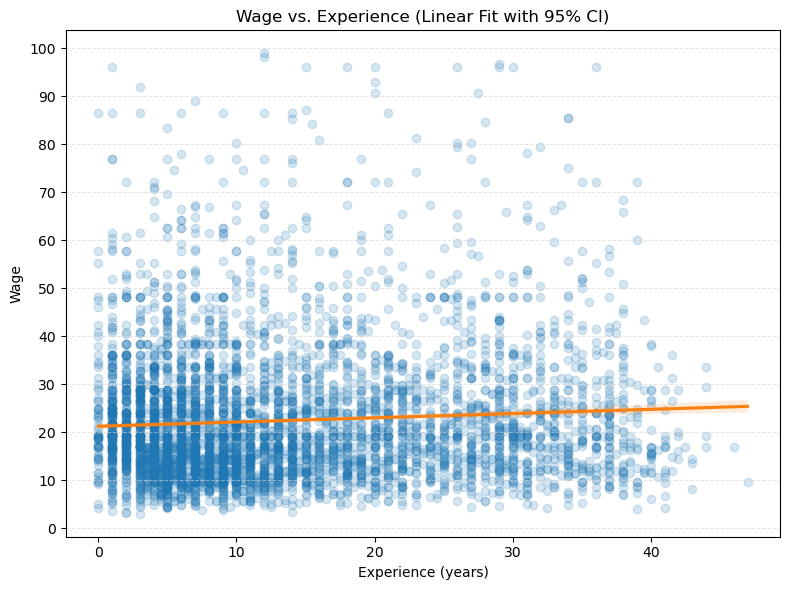

In [ ]:
# 绘制 wage 和 experience 的 '散点图+线性回归线 (+ 95% CI)' 图。

import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt

# 只用 wage < 100 的样本
df_plot = df_wage_less_100.copy()

plt.figure(figsize=(8, 6))
sns.regplot(
    data=df_plot,
    x='exp1', y='wage',
    scatter_kws={'alpha': 0.18, 'color': '#1f77b4'},
    line_kws={'color': '#ff7f0e'},
    ci=95
)
plt.xlabel('Experience (years)')
plt.ylabel('Wage')
plt.title('Wage vs. Experience (Linear Fit with 95% CI)')
plt.grid(axis='y', color='lightgray', linestyle='--', linewidth=0.7, alpha=0.6)
plt.yticks(np.arange(0, 105, 10))
plt.tight_layout()
plt.show()


## 分仓散点图

- 绘制 wage 和 experience 的 '分仓散点图 (binscatter)+线性回归线 (+ 95% CI)' 图。

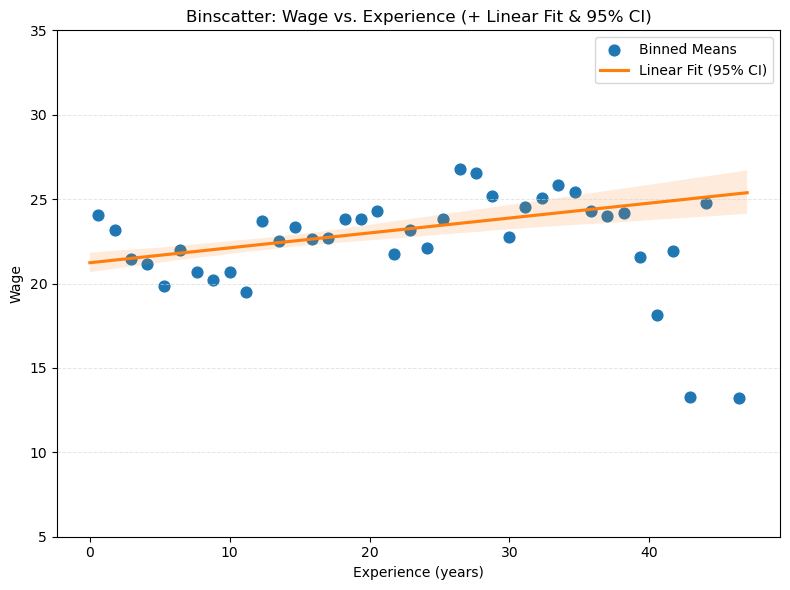

In [5]:
import seaborn as sns
import numpy as np
from scipy.stats import binned_statistic

import matplotlib.pyplot as plt

# 只用 wage < 100 的样本
df_wage_less_100 = df[df['wage'] < 100].copy()
df_plot = df_wage_less_100.copy()

# 设置分箱数量
n_bins = 40
bin_means, bin_edges, binnumber = binned_statistic(
    df_plot['exp1'], df_plot['wage'], statistic='mean', bins=n_bins
)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

plt.figure(figsize=(8, 6))
# 绘制分仓均值散点
plt.scatter(bin_centers, bin_means, color='#1f77b4', s=60, label='Binned Means')

# 拟合线性回归线和置信区间
sns.regplot(
    data=df_plot,
    x='exp1', y='wage',
    scatter=False,
    line_kws={'color': '#ff7f0e'},
    ci=95,
    label='Linear Fit (95% CI)'
)

plt.xlabel('Experience (years)')
plt.ylabel('Wage')
plt.title('Binscatter: Wage vs. Experience (+ Linear Fit & 95% CI)')
plt.grid(axis='y', color='lightgray', linestyle='--', linewidth=0.7, alpha=0.6)
plt.yticks(np.arange(5, 40, 5))
plt.legend()
plt.tight_layout()
plt.show()

### 变量构造

我们在本节中构造了输出变量 $Y$ 以及包含工人特征的特征矩阵 $Z$，这些特征均来源于原始数据集。

In [16]:
Y = np.log(df['wage'])
Z = df.drop(['wage', 'lwage', 'edu_group', 'region', 'sex_label'], axis=1)
Z.shape

(5150, 18)

For the outcome variable (log) wage and a subset of the raw regressors, we calculate the empirical mean and other empirical measures to get familiar with the data.



In [ ]:
stats = ['count', 'mean', 'std', 'min', 'max']
s = Z.describe().T.reset_index()
s = s[['index'] + stats]
s.columns = ['Variable'] + stats
print(s.round(2))

   Variable   count     mean       std    min        max
0       sex  5150.0     0.44      0.50    0.0       1.00
1       shs  5150.0     0.02      0.15    0.0       1.00
2       hsg  5150.0     0.24      0.43    0.0       1.00
3       scl  5150.0     0.28      0.45    0.0       1.00
4       clg  5150.0     0.32      0.47    0.0       1.00
5        ad  5150.0     0.14      0.34    0.0       1.00
6        mw  5150.0     0.26      0.44    0.0       1.00
7        so  5150.0     0.30      0.46    0.0       1.00
8        we  5150.0     0.22      0.41    0.0       1.00
9        ne  5150.0     0.23      0.42    0.0       1.00
10     exp1  5150.0    13.76     10.61    0.0      47.00
11     exp2  5150.0     3.02      4.00    0.0      22.09
12     exp3  5150.0     8.24     14.49    0.0     103.82
13     exp4  5150.0    25.12     53.53    0.0     487.97
14      occ  5150.0  5310.74  11874.36   10.0  100000.00
15     occ2  5150.0    11.67      6.97    1.0      22.00
16      ind  5150.0  6629.15   

例如，我们样本中女性工人占比约为 44%（$sex=1$ 表示女性）。

In [ ]:
# if you want to print this table to latex
print(Z.describe().style.to_latex())

## 预测

接下来，我们将构建一个关于小时（对数）工资 $Y$ 的预测规则，假设 $Y$ 与与工作相关的特征 $X$ 之间存在线性关系：

$$
Y = \beta' X + \epsilon \tag{1}
$$

我们的目标包括：

* 利用工人的多种特征预测工资水平，包括：
  - 教育水平（如高中毕业、大学毕业等）；
  - 工作经验（如潜在工作经验）；
  - 性别（男性或女性）；
  - 居住地区（如中西部、南部等）。
* 通过（调整后的）样本均方误差（MSE）、（调整后的）样本 $R^2$ 以及样本外的 MSE 和 $R^2$，评估模型的预测能力。
  
  - $MSE = \frac{1}{n} \sum_{i=1}^{n} (Y_i - \hat{Y}_i)^2$，其中 $\hat{Y}_i$ 是模型预测的工资；
  
  - $R^2 = 1 - \frac{MSE}{\text{Var}(Y)}$，其中 $\text{Var}(Y)$ 是工资的样本方差。
  - $\bar{R}^2 = 1 - \frac{(1-R^2)(n-1)}{n-k-1}$，其中 $k$ 是模型中使用的特征数量。
  - 样本外的 MSE 和 $R^2$ 是将基于训练样本得到的系数估计值带入测试样本中计算而得。

为实现上述目标，我们采用数据拆分（data splitting）的方法来衡量两种模型的预测效果：

- 随机将数据集分为训练集和测试集（更复杂的做法如分层抽样可进一步提升效果，这里仅用最基础的随机拆分）；
- 在训练集上估计基本模型和灵活模型的参数；
- 在使用测试集前，先评估模型在训练集上的拟合表现。


In [19]:
# 将数据集分为训练集和测试集，使用 80% 的数据作为训练集，20% 的数据作为测试集
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.20, random_state=123)

我们采用两种不同的预测模型设定：

1. **基础模型（Basic Model）**：$X$ 包含一组原始解释变量（如性别、工作经验、学历虚拟变量、职业和行业虚拟变量、地区虚拟变量等）。

2. **灵活模型（Flexible Model）**：$X$ 不仅包含基础模型中的所有原始解释变量，还加入了变量变换（如 ${exp}^2$、${exp}^3$ 等高次项）以及工作经验与其他解释变量的两两交互项。例如，“工作经验 × 大学学历指示变量”就是一种典型的交互项。

采用**灵活模型**可以用更复杂的回归函数来逼近真实关系，从而降低偏差。灵活模型拓展了回归函数的可能形状范围。一般来说，灵活模型往往能带来更高的预测准确性，但模型解释性会变弱。

我们也可以将灵活模型视为「变系数模型」，具体说明如下。

假设基础模型设定如下：

$$
Y_i = \alpha_1 + \beta X_{i} + \gamma W_{i} + \varepsilon_i \tag{2}
$$

其中 $X_i$ 是一组原始解释变量，$W_i$ 是一组控制变量。$X$ 对 $Y$ 的边际影响可以表示为：

$$
\frac{\partial Y_i}{\partial X_i} = \beta  \tag{3}
$$

在基础模型中，$\beta$ 是一个常数，表示 $X$ 对 $Y$ 的边际影响是恒定的。然而，现实中，$X$ 对 $Y$ 的影响可能会随着其他变量（如工作经验、教育水平等）的变化而变化。因此，我们可以将 $\beta$ 视为一个函数：

$$
\beta_i = \alpha_2 + \theta Z_i \tag{4}
$$

此处，$Z$ 可以是一个变量，也可以是一组变量。用 (4) 式中的 $\beta_i$ 替换 (2) 式中的 $\beta$，我们得到变系数模型：

$$
\begin{aligned}
Y_i &= \alpha_1 + \beta_i X_{i} + \gamma W_{i} + \varepsilon_i \\
    &= \alpha_1 + (\alpha_2 + \theta Z_i) X_{i} + \gamma W_{i} + \varepsilon_i \\
    &= \alpha_1 + \alpha_2 X_{i} + \theta Z_i X_{i} + \gamma W_{i} + \varepsilon_i \tag{5}
\end{aligned}
$$

在 (5) 式中，$Z_i X_{i}$ 表示 $Z_i$ 和 $X_i$ 的交互项。通过这种方式，我们可以捕捉到 $X$ 对 $Y$ 的边际影响如何随着其他变量的变化而变化。

需要说明的是，当 $Z=X$ 或 $Z = (X, X^2)$ 时，(5) 式中就会包含 $X$ 的平方项或更高次项，这样就可以捕捉到 $X$ 的非线性效应。


### 数据拆分与模型评估

数据拆分（Data-Splitting）是一种常用的模型评估方法。我们将数据集随机分为训练集（train）和测试集（test），通常比例为 80% : 20%。在训练集上拟合模型，并在测试集上评估模型的预测能力。这样可以有效避免模型过拟合，获得更真实的预测性能指标。

本节将分别对基础模型（Basic Model）和灵活模型（Flexible Model）进行训练集内（in-sample）性能评估，包括 $R^2$、调整 $R^2$、MSE 及调整 MSE 等指标。

接下来，我们对数据分别拟合基础模型和灵活模型，采用普通最小二乘法（OLS）进行估计：

In [20]:
# 1. Basic Model
model_base = 'lwage ~ sex + exp1 + shs + hsg+ scl + clg + mw + so + we + C(occ2) + C(ind2)'
base = smf.ols(model_base, data=train)
results_base = base.fit()

In [ ]:
rsquared_base = results_base.rsquared
rsquared_adj_base = results_base.rsquared_adj
mse_base = np.mean(results_base.resid**2)
mse_adj_base = results_base.mse_resid
print(f'Rsquared = {rsquared_base:.4f}')
print(f'Rsquared_adjusted = {rsquared_adj_base:.4f}')
print(f'MSE = {mse_base:.4f}')
print(f'MSE_adjusted = {mse_adj_base:.4f}')

Rsquared=0.3176
Rsquared_adjusted=0.3092
MSE=0.2202
MSE_adjusted=0.2229


In [32]:
# verify the formulas
X, y = base.data.exog, base.data.endog
n, p = X.shape
mse = np.mean((y - results_base.predict(X, transform=False))**2)
mse_adj = mse * n / (n - p)
rsquared = 1 - mse / np.var(y)
rsquared_adj = 1 - mse_adj / np.var(y)
print(f'Rsquared = {rsquared:.4f}')
print(f'Rsquared_adjusted = {rsquared_adj:.4f}')
print(f'MSE = {mse:.4f}')
print(f'MSE_adjusted = {mse_adj:.4f}')

Rsquared = 0.3176
Rsquared_adjusted = 0.3091
MSE = 0.2202
MSE_adjusted = 0.2229


In [35]:
# 2. Flexible Model
model_flex = ('lwage ~ sex + shs+hsg+scl+clg+C(occ2)+C(ind2)+mw+so+we '
              '+ (exp1+exp2+exp3+exp4)*(shs+hsg+scl+clg+C(occ2)+C(ind2)+mw+so+we)')
flex = smf.ols(model_flex, data=train)
results_flex = flex.fit()

In [37]:
rsquared_flex = results_flex.rsquared
rsquared_adj_flex = results_flex.rsquared_adj
mse_flex = np.mean(results_flex.resid**2)
mse_adj_flex = results_flex.mse_resid
print(f'Rsquared = {rsquared_flex:.4f}')
print(f'Rsquared_adjusted = {rsquared_adj_flex:.4f}')
print(f'MSE = {mse_flex:.4f}')
print(f'MSE_adjusted = {mse_adj_flex:.4f}')

Rsquared = 0.3643
Rsquared_adjusted = 0.3241
MSE = 0.2051
MSE_adjusted = 0.2181


#### 使用 Lasso 重新估计灵活模型

我们用 Lasso（最小绝对收缩与选择算子）方法，重新估计灵活模型（Flexible Model），而不是采用 ols。Lasso 是一种带惩罚项的回归方法，适用于 $p/n$ 不小的情形，可以有效降低模型复杂度。关于 Lasso 的理论介绍将在后续课程详细展开，这里我们将其作为“黑箱”预测工具进行尝试。

我们在特征构造阶段依然使用 statsmodels 的 formula api，以保证变量处理的一致性；在模型估计阶段，采用 sklearn 的 Lasso，并通过交叉验证自动选择正则化参数。

In [38]:
# Lasso with cross-validation
X = flex.data.exog[:, 1:]  # exclude the intercept; we don't want the lasso to penalize the intercept
y = flex.data.endog

# train model using Lasso with cross validation and variable normalization
lasso = Pipeline([('scale', StandardScaler()),  # standardize the variables
                  ('lasso', lm.LassoCV())])
lasso.fit(X, y)

Pipeline(steps=[('scale', StandardScaler()), ('lasso', LassoCV())])

In [40]:
# verify the formulas
n, p = X.shape
p += 1
mse_lasso = np.mean((y - lasso.predict(X))**2)
mse_adj_lasso = mse_lasso * n / (n - p)
rsquared_lasso = 1 - mse_lasso / np.var(y)
rsquared_adj_lasso = 1 - mse_adj_lasso / np.var(y)
print(f'Rsquared = {rsquared_lasso:.4f}')
print(f'Rsquared_adjusted = {rsquared_adj_lasso:.4f}')
print(f'MSE = {mse_lasso:.4f}')
print(f'MSE_adjusted = {mse_adj_lasso:.4f}')

Rsquared = 0.3309
Rsquared_adjusted = 0.2885
MSE = 0.2159
MSE_adjusted = 0.2296


In [44]:
# store the results in a table
res_df = pd.DataFrame()

res_df['Model'] = ['Basic reg', 'Flexible reg', 'Flexible Lasso']

res_df['p'] = [results_base.params.shape[0],
               results_flex.params.shape[0],
               results_flex.params.shape[0]]

res_df['R2'] = [rsquared_base, rsquared_flex, rsquared_lasso]
res_df['MSE'] = [mse_base, mse_flex, mse_lasso]

res_df['adj_R2'] = [rsquared_adj_base, rsquared_adj_flex, rsquared_adj_lasso]
res_df['adj_MSE'] = [mse_adj_base, mse_adj_flex, mse_adj_lasso]

# Show results
print(res_df.head().round(3))

            Model    p     R2    MSE  adj_R2  adj_MSE
0       Basic reg   51  0.318  0.220   0.309    0.223
1    Flexible reg  246  0.364  0.205   0.324    0.218
2  Flexible Lasso  246  0.331  0.216   0.288    0.230


In [ ]:
# print to Latex
print(res_df.style.to_latex())

综合上述各项指标，灵活模型（Flexible Model）的表现略优于基础模型（Basic Model）。

由于 $p/n$ 并不大，调整前后的各项指标差异不大。但如果 $p/n$ 较大，调整项的影响会更明显。此时，为了防止过拟合，我们通常会采用**数据拆分（data splitting）**等更通用的策略。下面将通过具体例子进行说明。

## 数据拆分：样本外预测表现

在前面分析了样本内拟合效果后，我们进一步评估模型在样本外（out-of-sample）的预测能力：

- 使用测试集（testing sample）进行评估。对于测试集中的每个观测，利用训练集估计得到的参数预测其 $\mathtt{wage}$（工资）；
- 计算两种预测模型在测试集上的均方预测误差 $MSE_{test}$，即样本外均方误差。

通过这种方式，可以更真实地反映模型的泛化能力，避免仅凭样本内拟合效果（如 $R^2$、$MSE$）对模型优劣做出过于乐观的判断。


In [46]:
# 我们这里采用 smf.ols 仅用于提取完整的设计矩阵（data frame），
# 而实际样本外预测更方便用 sm.OLS。
# 这是因为 smf.ols 在样本外预测时处理较为繁琐。

tmp = smf.ols(model_base, data=df)  # 这里只是为了提取数据，不用于实际建模
X_full = tmp.data.exog
y_full = tmp.data.endog
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, 
                                                    test_size=0.2, 
                                                    shuffle=True)


In [50]:
# estimating the parameters in the training sample
regbasic = sm.OLS(y_train, X_train).fit()

# predict out of sample
yhat_reg_base = regbasic.predict(X_test)

# calculating out-of-sample MSE
MSE_test1 = sum((y_test - yhat_reg_base)**2) / y_test.shape[0]
R2_test1 = 1. - MSE_test1 / np.var(y_test)

print("Test MSE for the basic model: " + str(round(MSE_test1, 3)))
print("Test R2  for the basic model: " + str(round(R2_test1, 3)))

Test MSE for the basic model: 0.218
Test R2  for the basic model: 0.332


在基础模型中，$MSE_{test}$（样本外均方误差）与 $MSE_{sample}$（样本内均方误差）非常接近。

In [52]:
# 这里只用 smf.ols 提取完整的设计矩阵（data frame），实际样本外预测更方便用 sm.OLS
# 这是因为 smf.ols 在样本外预测时处理较为繁琐

tmp = smf.ols(model_flex, data=df)  # 这里只是为了提取数据，不用于实际建模
X_full = tmp.data.exog
y_full = tmp.data.endog
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=.2, shuffle=True)

# 在训练集上估计灵活模型参数
regflex = sm.OLS(y_train, X_train).fit()

# 用测试集进行样本外预测
yhat_reg_flex = regflex.predict(X_test)

# 计算样本外均方误差（MSE）和 $R^2$
MSE_test2 = np.mean((y_test - yhat_reg_flex)**2)
R2_test2 = 1. - MSE_test2 / np.var(y_test)

print("灵活模型的测试集 MSE: {:.3f}".format(MSE_test2))
print("灵活模型的测试集 R2: {:.3f}".format(R2_test2))

灵活模型的测试集 MSE: 0.243
灵活模型的测试集 R2: 0.292


在灵活模型（Flexible Model）设定下，样本外均方误差 $MSE_{test}$ 与样本内均方误差 $MSE_{sample}$ 的差距并不大。

需要注意的是，$MSE_{test}$ 会随着数据拆分的不同而有所波动。因此，通常建议对多次数据拆分下的样本外 $MSE$ 取平均，以获得更稳健的评估结果。

总体来看，基于样本外 $MSE$，采用 OLS 回归的基础模型（Basic Model）与灵活模型的预测表现相当，甚至基础模型略优。

接下来，我们将在灵活模型中用 Lasso 回归替代 OLS 回归。需要强调的是，样本外 $MSE$ 也可以用于评估其他任意“黑箱”预测方法。最后，我们将比较 Lasso 回归与 OLS 回归在灵活模型下的预测表现。

In [63]:
# train model using Lasso with cross validation and variable normalization
lasso = Pipeline([('scale', StandardScaler()),  # standardize the variables
                  ('lasso', lm.LassoCV())])
lasso.fit(X_train[:, 1:], y_train)

# predict out of sample
yhat_test_lasso = lasso.predict(X_test[:, 1:])

# calculating out-of-sample MSE
MSE_test3 = np.mean((y_test - yhat_test_lasso)**2)
R2_test3 = 1. - MSE_test3 / np.var(y_test)

print("Test MSE for the lasso model: {:.3f}".format(MSE_test3))
print("Test R2 for the lasso model: {:.3f}".format(R2_test3))

Test MSE for the lasso model: 0.231
Test R2 for the lasso model: 0.297


In [57]:
# store the results in a table
res_df2 = pd.DataFrame()

res_df2['Model'] = ['Basic reg', 'Flexible reg', 'Flexible Lasso']

res_df2['$MSE_{test}$'] = [MSE_test1, MSE_test2, MSE_test3]
res_df2['$R^2_{test}$'] = [R2_test1, R2_test2, R2_test3]

# Show results
print(res_df2.head().round(3))

            Model  $MSE_{test}$  $R^2_{test}$
0       Basic reg         0.218         0.332
1    Flexible reg         0.243         0.292
2  Flexible Lasso         0.233         0.321


In [ ]:
# print to Latex
print(res_df2.style.to_latex())



### 超灵活模型与过拟合

从前面的结果来看，Lasso 与 OLS 的预测表现差异并不大，似乎没有充分理由一定要用 Lasso。为了更好地说明 Lasso 的优势，我们引入一个“超灵活模型”（extra flexible model），展示 OLS 在高维协变量下如何严重过拟合训练集（in-sample），而在测试集（out-of-sample）上表现很差。

超灵活模型包含了大量变量及其交互项，极大地提升了模型复杂度。在这种设定下，OLS 可以在训练集上取得极高的 $R^2$，但由于模型过于贴合训练数据，导致泛化能力下降，测试集上的预测误差显著增大。这种现象就是典型的“过拟合”（overfitting）。

相比之下，Lasso 通过引入惩罚项（正则化），自动筛选和收缩部分系数，有效抑制了过拟合问题。即使在高维协变量下，Lasso 依然能保持较好的样本外预测能力。因此，在变量维度较高或模型复杂度较大时，Lasso 等正则化方法具有明显优势。

In [59]:
# Extra Flexible Model
model_extra = (
    'lwage ~ sex + (exp1 + exp2 + exp3 + exp4 + shs + hsg + scl + clg + C(occ2) + C(ind2) + mw + so + we) ** 2'
)
tmp = smf.ols(model_extra, data=df)  # just to extract df, not actually using this model

# In-sample fit
insamplefit = tmp.fit()
rsquared_ex = insamplefit.rsquared
rsquared_adj_ex = insamplefit.rsquared_adj
mse_ex = np.mean(insamplefit.resid ** 2)
mse_adj_ex = insamplefit.mse_resid
print(f'(In-sample) Rsquared = {rsquared_ex:.4f}')
print(f'(In-sample) Rsquared_adjusted = {rsquared_adj_ex:.4f}')
print(f'(In-sample) MSE = {mse_ex:.4f}')
print(f'(In-sample) MSE_adjusted = {mse_adj_ex:.4f}')

# Train test Split
X_full = tmp.data.exog
y_full = tmp.data.endog
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.2, shuffle=True)

# estimating the parameters in the training sample
regextra = sm.OLS(y_train, X_train).fit()

# predict out of sample
yhat_reg_extra = regextra.predict(X_test)

# calculating out-of-sample MSE
MSE_test4 = np.mean((y_test - yhat_reg_extra) ** 2)
R2_test4 = 1. - MSE_test4 / np.var(y_test)

print(f"Test MSE for the flexible model: {MSE_test4:.4f}")
print(f"Test R2 for the flexible model: {R2_test4:.4f}")

(In-sample) Rsquared = 0.4489
(In-sample) Rsquared_adjusted = 0.3506
(In-sample) MSE = 0.1793
(In-sample) MSE_adjusted = 0.2113
Test MSE for the flexible model: 0.2650
Test R2 for the flexible model: 0.1925


可以看到，当协变量维度很高时，简单的 OLS 回归会出现明显的过拟合现象：样本内（in-sample）拟合效果非常好，但样本外（out-of-sample）预测能力却大幅下降。

与此对比，Lasso 方法表现如下：

In [60]:
np.sum(lasso.named_steps['lasso'].coef_ != 0)

85

In [62]:
# train model using Lasso with cross validation and variable normalization
lasso = Pipeline([('scale', StandardScaler()),  # standardize the variables
                  ('lasso', lm.LassoCV())])
lasso.fit(X_train[:, 1:], y_train)

# predict in sample
yhat_train_lasso = lasso.predict(X_train[:, 1:])

# Calculate R-squared
R2_L = 1 - np.sum((yhat_train_lasso - y_train)**2) / np.sum((y_train - np.mean(y_train))**2)

# Calculate adjusted R-squared
pL = np.sum(lasso.named_steps['lasso'].coef_ != 0)
ntrain = len(X_train)
baseline = np.sum((y_train - np.mean(y_train))**2) / (ntrain - 1)
R2_adjL = 1 - (np.sum((yhat_train_lasso - y_train)**2) / (ntrain - pL - 1)) / baseline

# Calculate Mean Squared Error (MSE)
lasso_res = y_train - yhat_train_lasso
MSEL = np.mean(lasso_res**2)

# Calculate adjusted MSE
MSE_adjL = (ntrain / (ntrain - pL - 1)) * MSEL

# Print the results
print("R-squared for the lasso with the extra flexible model (in-sample):", round(R2_L, 3))
print("Adjusted R-squared for the extra flexible model (in-sample):", round(R2_adjL, 3))
print("MSE for the lasso with the extra flexible model (in-sample):", round(MSEL, 3))
print("Adjusted MSE for the lasso with the extra flexible model (in-sample):", round(MSE_adjL, 3))

# predict out of sample
yhat_test_lasso = lasso.predict(X_test[:, 1:])

# calculating out-of-sample MSE
MSE_test5 = np.mean((y_test - yhat_test_lasso)**2)
R2_test5 = 1. - MSE_test5 / np.var(y_test)

print("Test MSE for the lasso with the extra flexible model: {:.3f}".format(MSE_test5))
print("Test R2 for the lasso with the extra flexible model: {:.3f}".format(R2_test5))

R-squared for the lasso with the extra flexible model (in-sample): 0.361
Adjusted R-squared for the extra flexible model (in-sample): 0.33
MSE for the lasso with the extra flexible model (in-sample): 0.207
Adjusted MSE for the lasso with the extra flexible model (in-sample): 0.217
Test MSE for the lasso with the extra flexible model: 0.231
Test R2 for the lasso with the extra flexible model: 0.297


如上所示，惩罚回归模型（如 Lasso）能够有效缓解过拟合（overfitting）问题。

- 在高维特征或模型复杂度较高的情况下，普通最小二乘法（OLS）往往会出现“样本内拟合很好、样本外预测很差”的现象，即过拟合。
- 而引入惩罚项的回归方法（如 Lasso），通过对系数收缩和变量选择，能够提升模型的泛化能力，使得样本外 $Y$ 的预测表现更加稳健。

因此，在 $X$ 维度较高或变量间存在多重共线性的实际应用中，Lasso 等正则化方法是防止过拟合、提升预测准确性的有效工具。